In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import panel as pn
import seaborn as sns
import statsmodels.api as sm

sns.set("notebook")
plt.rcParams["figure.constrained_layout.use"] = True

# Carga de los datos

In [2]:
df = pd.read_csv(
    "https://drive.google.com/uc?export=download&id=1zsFX4PUehK_rmLtP-1hqPnSo86VMHDAm"
)

In [3]:
region = (
    pd.read_csv(
        "https://github.com/open-numbers/ddf--gapminder--systema_globalis/raw/master/ddf--entities--geo--country.csv"
    )
    .replace(
        {
            "name": {
                "Central African Republic": "Central African Rep.",
                "North Macedonia": "Macedonia, FYR",
                "South Korea": "Korea, Rep.",
                "Yemen": "Yemen, Rep.",
                "Dominican Republic": "Dominican Rep.",
                "UK": "United Kingdom",
                "Czech Republic": "Czech Rep.",
                "USA": "United States",
            },
            # Se ajusta esta región porque solo incluye a un país del dataset y eos dificulta más adelante la imputación:
            "un_sdg_region": {
                "un_oceania_exc_australia_and_new_zealand": "un_otra",
            },
        }
    )
    .set_index("name")[["un_sdg_region", "income_groups"]]
)

In [4]:
df["region"] = (
    df.join(region, on="country")["un_sdg_region"]
    .str[3:]
    .str.replace("_", " ")
    .str.title()
).fillna("Otra")

df["income_groups"] = df.join(region, on="country")["income_groups"]

# 1. Entendimiento de los datos

## Diccionario

**country**: Unique Identifier

**incomeperperson**: 2010 Gross Domestic Product per capita in constant 2000 US$. The inflation but not the differences in the cost of living between countries has been taken into account.

**alcconsumption**: 2008 Alcohol consumption per adult (age 15+), litres Recorded and estimated average alcohol consumption, adult (15+) per capita consumption in litres pure alcohol

**armedforcesrate**: Armed forces personnel (% of the total labour force)

**breastcancerper100TH**: 2002 breast cancer new cases per 100,000 females. Number of new cases of breast cancer in 100,000 female residents during a certain year.

**co2emissions**: 2006 cumulative CO2 emission (metric tons), Total amount of CO2 emission in metric tons since 1751.

**femaleemployrate**: 2007 female employees age 15+ (% of the population). Percentage of female population, age above 15, that has been employed during the given year.

**HIVrate**: 2009 estimated HIV Prevalence % - (Ages 15-49). Estimated number of people living with HIV per 100 population of age group 15-49.

**Internetuserate**: 2010 Internet users (per 100 people). Internet users are people with access to the worldwide network.

**lifeexpectancy**: 2011 life expectancy at birth (years). The average number of years a newborn child would live if current mortality patterns were to stay the same.

**oilperperson**: 2010 oil Consumption per capita (tonnes per year and person).

**polityscore**: 2009 Democracy score (Polity).Overall polity score from the Polity IV dataset, calculated by subtracting an autocracy score from a democracy score. The summary measure of a country's democratic and free nature. -10 is the lowest value, 10 the highest.

**relectricperperson** 2008 residential electricity consumption, per person (kWh). The amount of residential electricity consumption per person during the given year, counted in kilowatt-hours (kWh).

**suicideper100TH**: Suicide, age-adjusted, per 100,000 Mortality due to self-inflicted injury, per 100,000 standard population, age-adjusted.

**employrate**: 2007 total employees age 15+ (% of the population). Percentage of the total p population, age above 15, that has been employed during the given year.

**urbanrate:** Urban population (% of total) Urban population refers to people living in urban areas as defined by national statistical offices (calculated using World Bank population estimates and urban ratios from the United Nations World Urbanization Prospects)

## 1.1 Tipos de datostodas las columnas son indicadores numéridos  

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   country               178 non-null    object 
 1   incomeperperson       175 non-null    float64
 2   alcconsumption        178 non-null    float64
 3   armedforcesrate       174 non-null    float64
 4   breastcancerper100th  177 non-null    float64
 5   co2emissions          176 non-null    float64
 6   femaleemployrate      177 non-null    float64
 7   hivrate               155 non-null    float64
 8   internetuserate       174 non-null    float64
 9   lifeexpectancy        178 non-null    float64
 10  oilperperson          67 non-null     float64
 11  polityscore           167 non-null    float64
 12  relectricperperson    141 non-null    float64
 13  suicideper100th       178 non-null    float64
 14  employrate            177 non-null    float64
 15  urbanrate             1

Como se observa en la tabla anterior, y de acuerdo con el diccionario de datos, con excepción de la columna `country` todas las columnas son indicadores numéridos  

## 1.3 Análisis univariado

In [6]:
df.describe().T.style.format("{:0,.1f}")

,count,mean,std,min,25%,50%,75%,max
incomeperperson,175.0,"7,553.4","11,074.6",103.8,609.7,"2,425.5","8,880.4","52,301.6"
alcconsumption,178.0,6.8,5.1,0.0,2.4,5.9,10.0,23.0
armedforcesrate,174.0,1.4,1.5,0.0,0.5,0.9,1.6,9.8
breastcancerper100th,177.0,37.6,23.2,3.9,20.4,30.0,50.3,101.1
co2emissions,176.0,"5,757,754,075.8","27,346,900,675.4","850,666.7","87,557,250.0","305,479,166.6","2,391,800,583.0","334,000,000,000.0"
femaleemployrate,177.0,47.6,14.7,12.4,38.8,48.4,56.0,83.3
hivrate,155.0,1.9,4.3,0.1,0.1,0.4,1.2,25.9
internetuserate,174.0,34.7,28.1,0.2,9.9,29.9,56.0,95.6
lifeexpectancy,178.0,69.4,9.8,47.8,62.7,73.0,76.1,83.4
oilperperson,67.0,1.4,1.8,0.0,0.6,0.9,1.6,12.2


En la tabla anterior se observan algunos valores posiblemente erroneos, en particular parece extraño que existan países en que el consumo electrico por persona sea cero, aunque puede que sea aproximadamente cero . 

In [7]:
df.loc[df["relectricperperson"] == 0, "country"]

13        Iraq
175    Namibia
Name: country, dtype: object

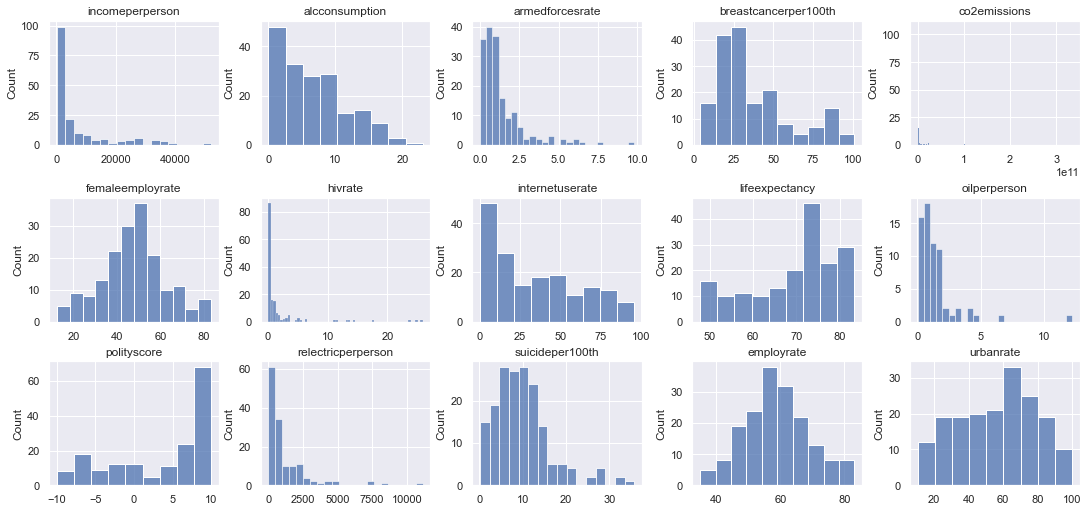

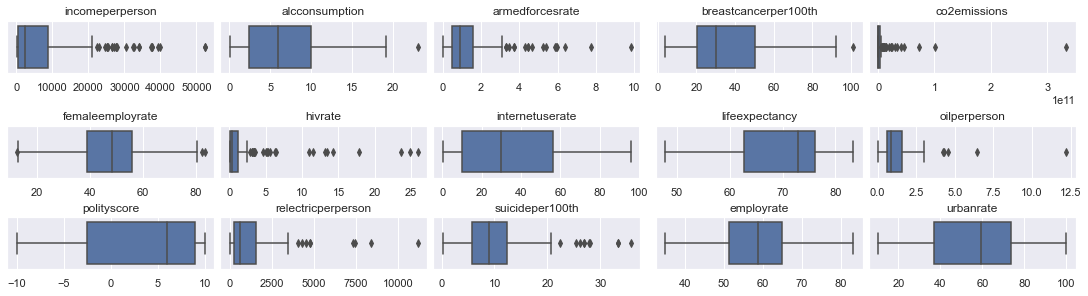

In [8]:
fig, axes = plt.subplots(3, 5, figsize=(15, 7))

for col, ax in zip(df.drop(columns="country"), axes.flat):
    sns.histplot(df, x=col, ax=ax)
    ax.set_title(col)
    ax.set_xlabel(None)

fig, axes = plt.subplots(3, 5, figsize=(15, 4))

for col, ax in zip(df.drop(columns="country"), axes.flat):
    ax = sns.boxplot(df, x=col, ax=ax)
    ax.set_title(col)
    ax.set_xlabel(None)

De las gráficas anteriores se pueden observar valores atípicos en bastantes de las variables. Para intentar mitigar este efecto se propone aplicar logaritmo a estas variables con lo cual se espera obtener un distribución más cercana a una normal:

In [9]:
power_law_vars = [
    "incomeperperson",
    "alcconsumption",
    "armedforcesrate",
    "breastcancerper100th",
    "co2emissions",
    "hivrate",
    "oilperperson",
    "relectricperperson",
    "suicideper100th",
]

for col in power_law_vars:
    df[f"log_{col}"] = df[col].pipe(np.log1p)

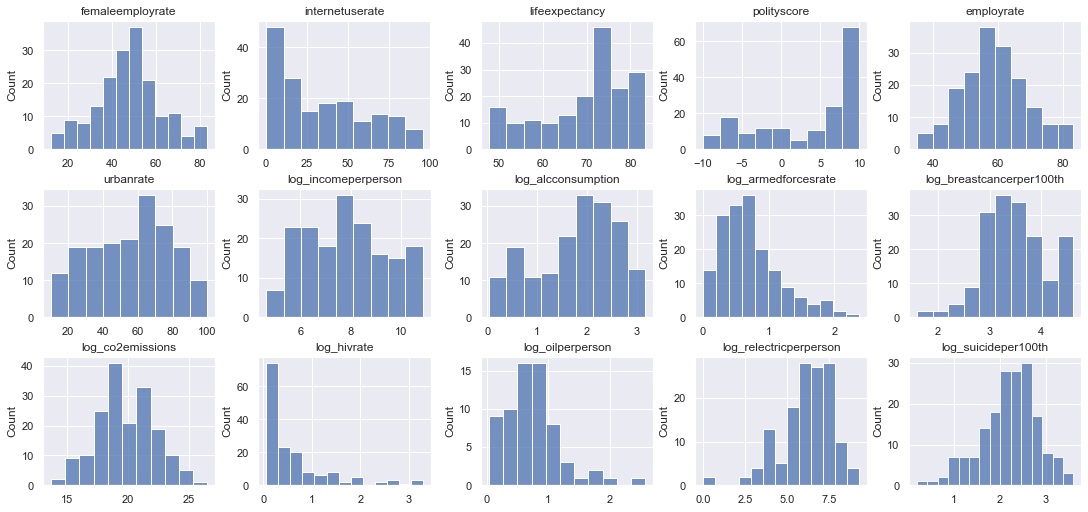

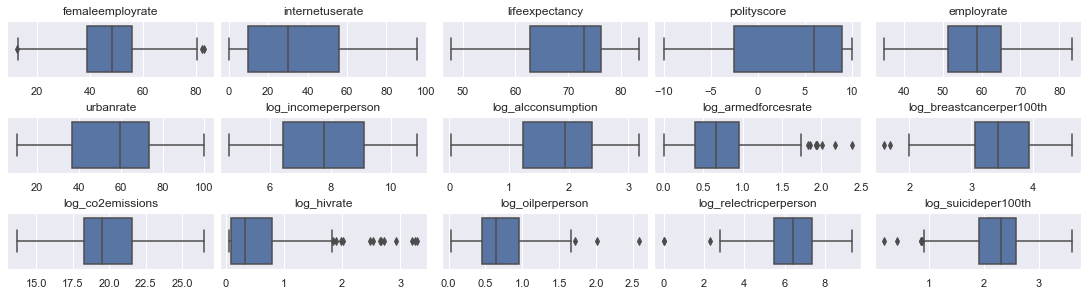

In [10]:
fig, axes = plt.subplots(3, 5, figsize=(15, 7))

for col, ax in zip(
    df.drop(columns=["country", "region", "income_groups"]).drop(
        columns=power_law_vars
    ),
    axes.flat,
):
    sns.histplot(df, x=col, ax=ax)
    ax.set_title(col)
    ax.set_xlabel(None)

fig, axes = plt.subplots(3, 5, figsize=(15, 4))

for col, ax in zip(
    df.drop(columns=["country", "region", "income_groups"]).drop(
        columns=power_law_vars
    ),
    axes.flat,
):
    ax = sns.boxplot(df, x=col, ax=ax)
    ax.set_title(col)
    ax.set_xlabel(None)

Vemos que con esta transformación se mitiga el efecto de los datos extremos en varias de las variables y se obstienen distribuciones más cercanas a una normal. Aunque aun persisten algunos valores atípicos.

# Análisis bivariado

C:\Users\yacha\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\yacha\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


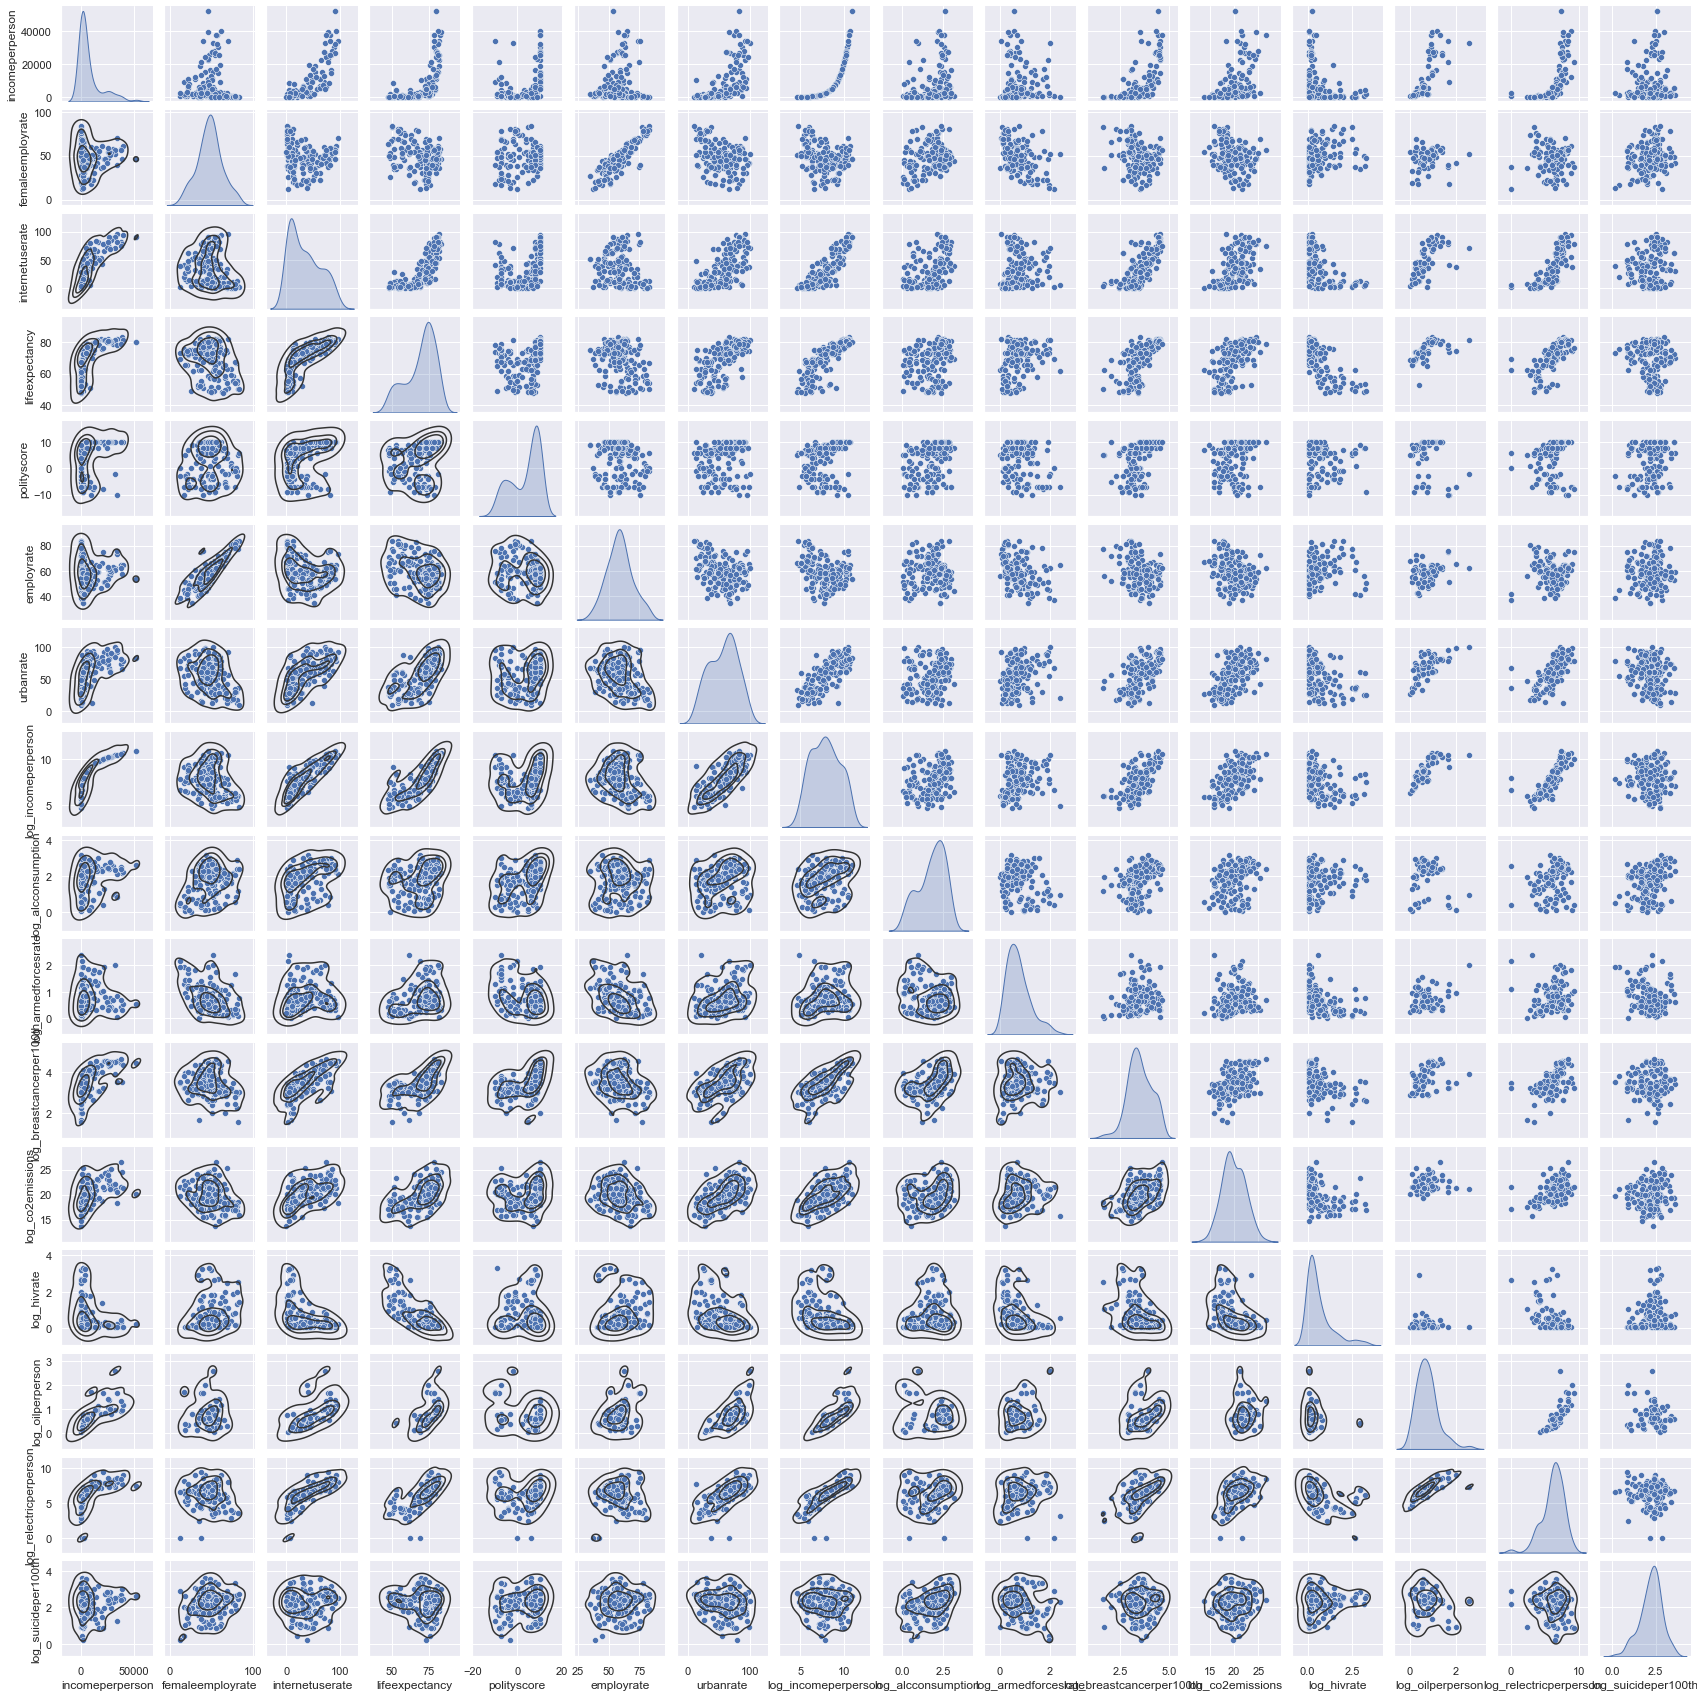

In [11]:
g = sns.pairplot(
    df.drop(
        columns=[
            "alcconsumption",
            "armedforcesrate",
            "breastcancerper100th",
            "co2emissions",
            "hivrate",
            "oilperperson",
            "relectricperperson",
            "suicideper100th",
        ]
    ),
    diag_kind="kde",
    height=1.5,
)
g.map_lower(sns.kdeplot, levels=4, color=".2")

A partir de la gráfica anterior es posible observar que existen varias variables que tienen una fuerte relación con en el ingreso per cápita y que esta relación es aproximadamente lineal con el logaritmo de esta variable. Lo cual es particularmente notorio en el caso de:
- **internetuserate**
- **log relectricperperson**
- **breastcancerper100th**
- **urbanrate**
- **log oilperperson**

### Análisis de correlaciones

<Axes: >

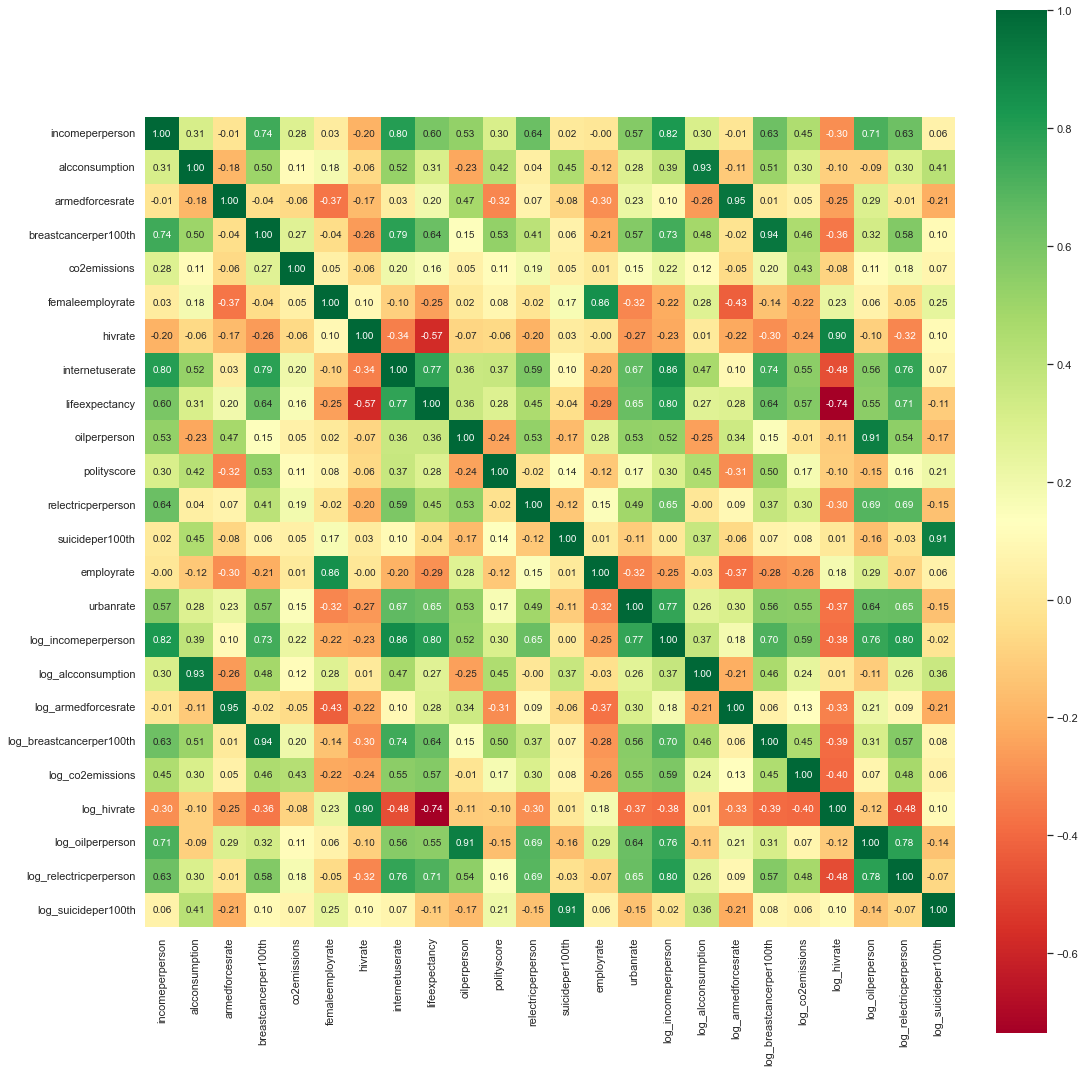

In [12]:
plt.figure(figsize=(15, 15))
sns.heatmap(
    df.corr(numeric_only=True), annot=True, square=True, fmt="0.2f", cmap="RdYlGn"
)

<Axes: title={'center': 'Con log_incomeperperson'}>

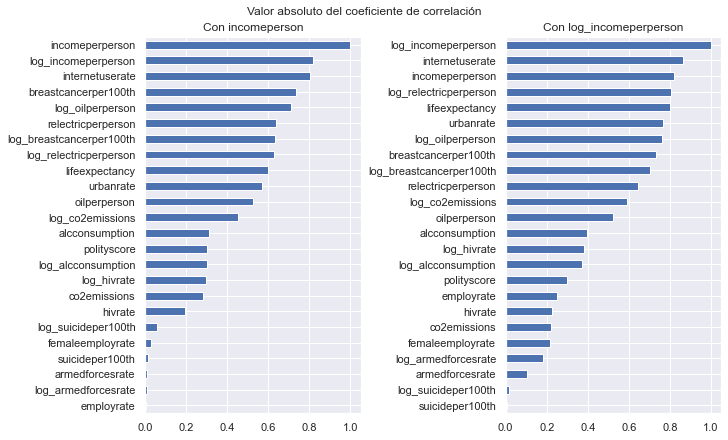

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6), layout="constrained")

fig.suptitle("Valor absoluto del coeficiente de correlación")

df.corr(numeric_only=True).abs()["incomeperperson"].sort_values().plot.barh(
    title="Con incomeperson",
    ax=ax1,
)

df.corr(numeric_only=True).abs()["log_incomeperperson"].sort_values().plot.barh(
    title="Con log_incomeperperson",
    ax=ax2,
)

De las dos gráficas anteriores se seleccionan las cinco variables que tienen mayor correlación con el ingreso o logaritmo del ingreso:

- **internetuserate**
- **relectricperperson**
- **breastcancerper100th**
- **urbanrate**
- **oilperperson**

In [14]:
indicadores_claves = [
    "log_incomeperperson",
    "internetuserate",
    "relectricperperson",
    "breastcancerper100th",
    "urbanrate",
    "oilperperson",
]

C:\Users\yacha\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\yacha\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


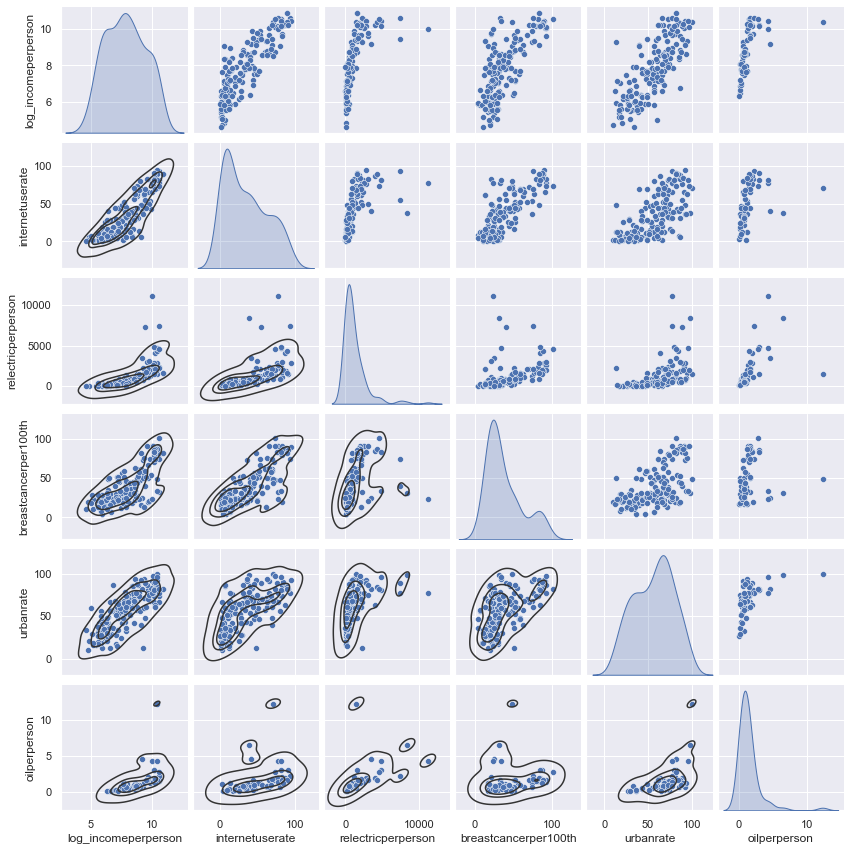

In [15]:
g = sns.pairplot(
    df,
    vars=indicadores_claves,
    diag_kind="kde",
    height=2,
)
g.map_lower(sns.kdeplot, levels=4, color=".2");

## Comportamiento de los indicadores por región

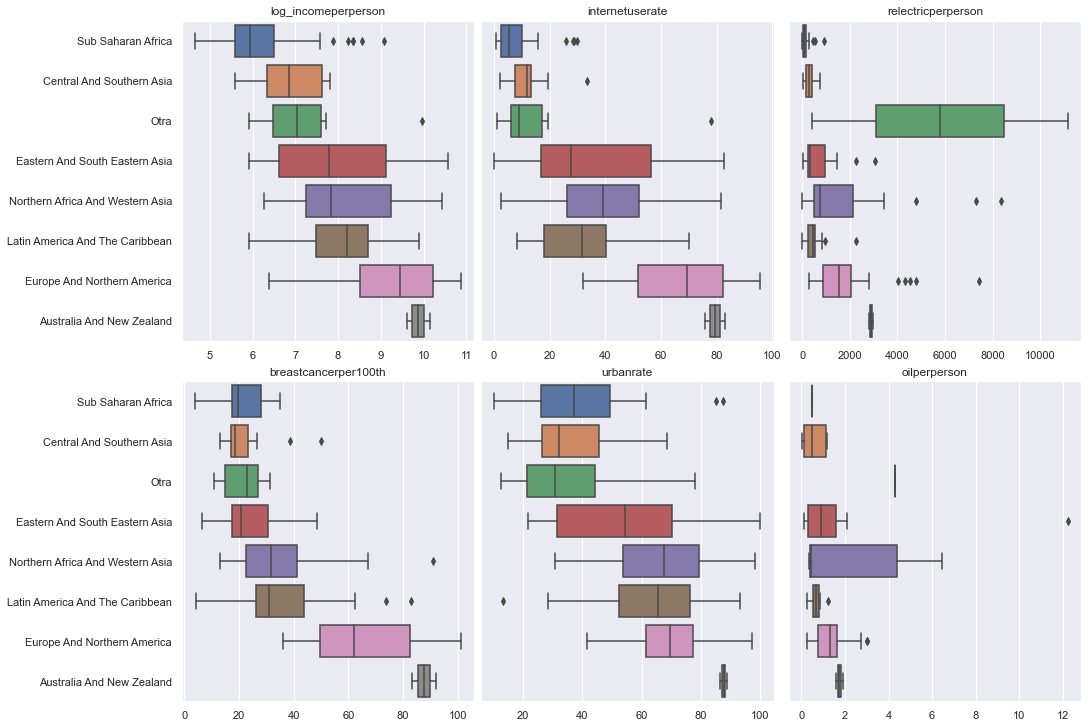

In [16]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharey=True)
regiones = df.groupby(["region"])["log_incomeperperson"].mean().sort_values().index

for indicador, ax in zip(indicadores_claves, axes.flat):
    sns.boxplot(df, y="region", x=indicador, ax=ax, order=regiones)
    ax.set_title(indicador)
    ax.set_xlabel(None)
    ax.set_ylabel(None)

En la gráfica anterior podemos observar que la región es una variable que se relaciona con todos los indicadores seleccionados. En particular es posible observar que Australia, Nueva Zelanda, Europa y Norte América tienden a tener un desempeño más alto. Aunque en los grupos se encuentran países a típicos, como es el caso de los países con relativamente altos ingresos en AFríca 

# 2. Preparación de datos

In [17]:
variables_sin_transormar = df.columns[~df.columns.str.startswith("log_")]

## Completitud (Datos Faltantes)

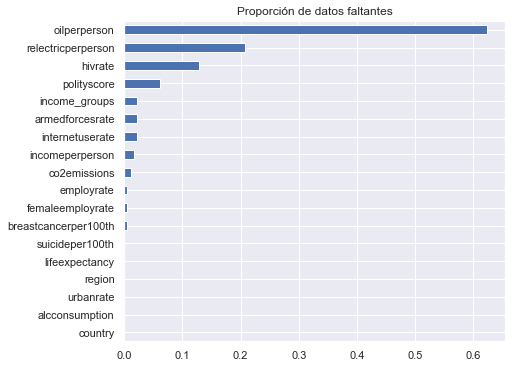

,Faltantes
country,0.0%
alcconsumption,0.0%
urbanrate,0.0%
region,0.0%
lifeexpectancy,0.0%
suicideper100th,0.0%
breastcancerper100th,0.6%
femaleemployrate,0.6%
employrate,0.6%
co2emissions,1.1%


In [18]:
faltantes = df[variables_sin_transormar].isna().mean(axis=0).sort_values()


faltantes.plot.barh(title="Proporción de datos faltantes", figsize=(7, 5))
plt.show()
faltantes.rename("Faltantes").to_frame().style.format("{:0.1%}")

Como se puede observar en la gráfica anterior, se encuentran bastantes datos faltantes, principalmente en las variables `oilperperson` (62.4%), `relectricperperson` (20.8%) y `hivrate` (12.9%).

**Consistencia ✅**: No se identifican problemas de consistencia en la medida en que las variables incluidas no permiten establecer contradicciones entre sí.

**Procesabilidad ✅**: Los datos son procesables en la medida en que todos se encuentran en un formato que perite su uso inmediato.

**Disponibilidad ✅**: Los datos se encuentran disponibles y dado que se trata de un análisis puntual no existe un problema en terminos de la latencia para acceder a los mismos. Sin embargo, los tiempos de actualización de los datos implican que no es facil mantener estos análisis actualizados en caso de que se requiera. 

**Temporalidad ⚠️**: De aceurdo al diccionario es posible observar que no todas las variables estan actualizadas al mismo periodo, sin emabrgo, se considera que esto puede no ser un problema mayor en la medida en que no se esperan cambios abruptos en estos indicadores, aunque es algo a tener en cuenta y que no se puede descartar. Adicionalmente el dataset es relativamente viejo 2007-2011, por lo que algunas de las relaciones que se identifiquen pueden ya no mantenerse.

**Credibilidad ⚠️**: De acuerdo con el portal GapMinder: "Most of our data are not good enough for detailed numeric analysis" [(enlace)](https://www.gapminder.org/data/documentation/). Por lo que es posible que las fuentes de información puedan tener algunos problemas de credibilidad, pues los datos son recolectados de fuentes diversas y GapMinder intenta llenar los vacíos que encuentra. 

**Completitud ⚠️**: Se identifican datos faltantes en varias variables (ver más arriba) por lo que será necesario eliminar algunas de ellas o hacer imputaciones en los casos en  que el porcentaje de datos faltantes no es tan elevado.



## Remediación de datos faltantes

De las variables consideradas claves se propone lo siguente para remediar los problemas de completitud:

* **incomeperperson**: Eliminar las filas con datos faltantes, dado que esta es la variable que se pretende explicar.
* **oilperson**: Elimminar esta columna, dado que el porcentaje de datos faltantes es demaciado alto.
* **relectricperperson**, **breastcancerper100th**, **internetuserate**: imputar estos valores con la mediana de los países de la misma región y grupo de ingresos. Se utilizará la mediana, dado que se observan algunos valores extremos en algunas de estas variables y se quiere utilizar un método robusto.

In [19]:
# Asignando paices con cero uso de energia por persona como datos faltantes
df["relectricperperson"] = df["relectricperperson"].replace(0, np.nan)

In [20]:
# Eliminando filas con ingreso per cápita faltante:
df = df.dropna(subset="incomeperperson")

In [21]:
df[indicadores_claves].isna().sum()

log_incomeperperson       0
internetuserate           3
relectricperperson       38
breastcancerper100th      1
urbanrate                 0
oilperperson            109
dtype: int64

Antes de avanzar con la imputación separamos los datos entre test y train, para garantizar que las estadísticas que se utilicen en la imputación no utilicen los datos de test.

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df[
        [
            "internetuserate",
            "relectricperperson",
            "breastcancerper100th",
            "urbanrate",
            "region",
            "income_groups",
        ]
    ],
    df["incomeperperson"],
    test_size=0.3,
    random_state=0,
    # Estratificamos por regiones para garantizar que todas las regiones están en test y train en proporciones similares
    stratify=df["region"],
)

In [23]:
medianas = (
    X_train.groupby(["region", "income_groups"]).quantile(0.5).add_prefix("median_")
)

medianas.style.format("{:0.2f}")

In [24]:
for col in medianas:
    col = col[7:]
    # Imputanos X_train
    X_train[col] = X_train[col].fillna(
        X_train.join(medianas, on=["region", "income_groups"])[f"median_{col}"]
    )

    # Imputanos X_test (con las medianas calculadas en X_train)
    X_test[col] = X_test[col].fillna(
        X_test.join(medianas, on=["region", "income_groups"])[f"median_{col}"]
    )

En los casos en que no se contó con un valor en la misma región y grupo de ingresos se imputá el valor utilizando únicamente el nivel de ingresos:


In [25]:
medianas = (
    X_train.groupby(["income_groups"])
    .quantile(0.5, numeric_only=True)
    .add_prefix("median_")
)


for col in medianas:
    col = col[7:]
    # Imputanos X_train
    X_train[col] = X_train[col].fillna(
        X_train.join(medianas, on=["income_groups"])[f"median_{col}"]
    )

    # Imputanos X_test (con las medianas calculadas en X_train)
    X_test[col] = X_test[col].fillna(
        X_test.join(medianas, on=["income_groups"])[f"median_{col}"]
    )

In [26]:
# Eliminamos la columnas income_groups ya que no la vamos a usar y cualquier fila en que hayan persistido datos faltantes
X_test = X_test.drop(columns="income_groups")
X_train = X_train.drop(columns="income_groups")

In [27]:
y_test = y_test[~X_test.isna().any(axis=1)]
X_test = X_test.dropna()

y_train = y_train[~X_train.isna().any(axis=1)]
X_train = X_train.dropna()

# Entrenamiento del modelo de regresión:

## Codificación de variable categórica (Región)

Dado que la región es una variable categórica se utiliza OneHot Encoder para codificarla:

In [28]:
X_train = pd.get_dummies(X_train, columns=["region"], drop_first=True)
X_test = pd.get_dummies(X_test, columns=["region"], drop_first=True)

## Verificando si la relación es aproximadamente lineal

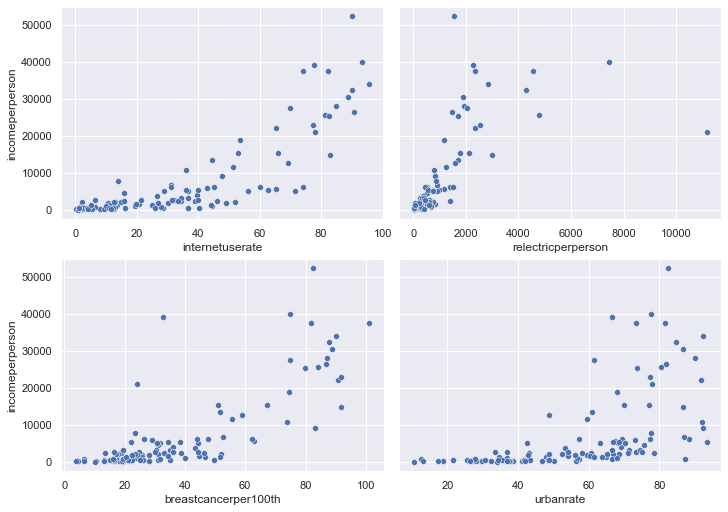

In [29]:
fig, axes = plt.subplots(2, 2, figsize=(10, 7), sharey=True)
for col, ax in zip(
    [
        "internetuserate",
        "relectricperperson",
        "breastcancerper100th",
        "urbanrate",
    ],
    axes.flat,
):
    sns.scatterplot(x=X_train[col], y=y_train, ax=ax)

De la gráfica anterior se puede inferir que la relación no es realmente lineal. De hecho en algunos de los casos la relación parece exponencial. Por ello se propone aplicar algunas transformaciones a los datos:

* incomeperperson -> log
* relectricperperson -> log

In [30]:
y_train_log = np.log(y_train).rename("log_incomeperperson")
X_train["log_relectricperperson"] = X_train["relectricperperson"].pipe(np.log1p)
X_train = X_train.drop(columns=["relectricperperson"])

y_test_log = np.log(y_test).rename("log_incomeperperson")
X_test["log_relectricperperson"] = X_test["relectricperperson"].pipe(np.log1p)
X_test = X_test.drop(columns=["relectricperperson"])

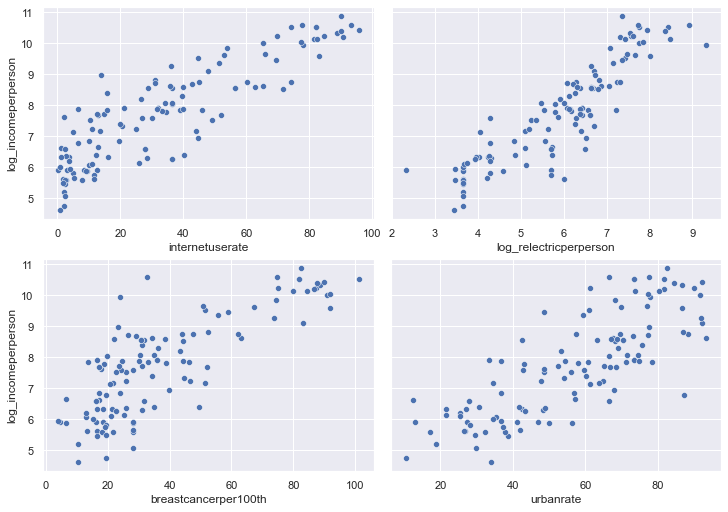

In [31]:
fig, axes = plt.subplots(2, 2, figsize=(10, 7), sharey=True)
for col, ax in zip(
    [
        "internetuserate",
        "log_relectricperperson",
        "breastcancerper100th",
        "urbanrate",
    ],
    axes.flat,
):
    sns.scatterplot(x=X_train[col], y=y_train_log, ax=ax)

Con estas transformaciones observamos ahora unas relaciones aproximadamente lineales

## Entrenamiento

In [32]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

model = LinearRegression()
model.fit(X_train, y_train_log);

## Evaluación

In [33]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred_log = model.predict(X_test)

# Dado que aplicamos logaritmo, se aplica la operación inversa:
y_pred = np.exp(y_pred_log)

print(
    f"""
MAE: {mean_absolute_error(y_test, y_pred)}
RMSE: {mean_squared_error(y_test, y_pred, squared=False)}
R^2: {r2_score(y_test, y_pred)}
"""
)


MAE: 3256.652934975392
RMSE: 5981.011550765352
R^2: 0.7097036385819444



En las métricas anteriores se observa un error relativamente grande, lo cual es de esperarse en la medida en que el PIB es una variable compleja pero probablemente este influenciada por muchos otros factors, sin embargo, el $R^2$ parece relativamente alto para la sencillez del modelo que se está ajustando. 

## Verificación de supuestos

### No Multicolinealidad

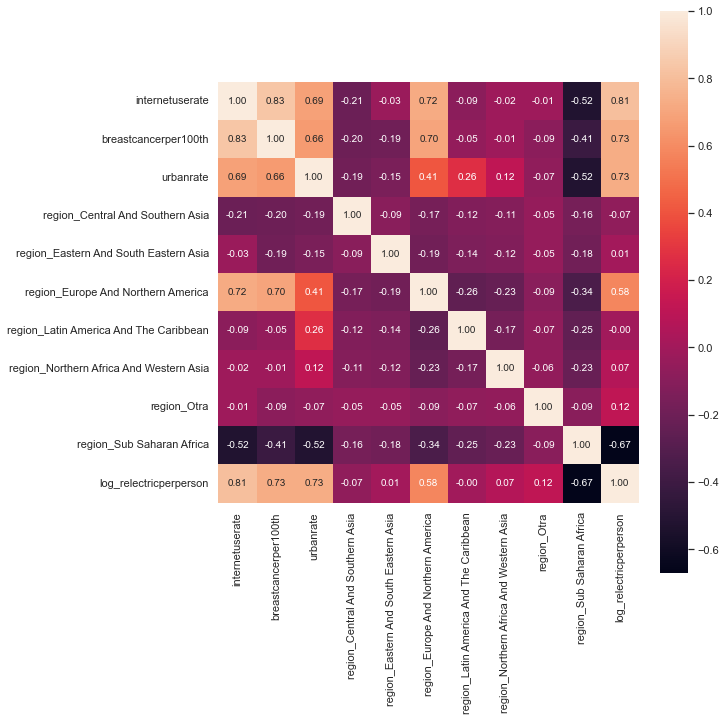

In [34]:
plt.figure(figsize=(10, 10))
sns.heatmap(X_train.corr(), square=True, annot=True, fmt="0.2f");

In [35]:
X_train.corr().abs().stack().pipe(lambda x: x[x != 1]).sort_values(
    ascending=False
).head(10).rename("Correlación").to_frame()

,,Correlación
internetuserate,breastcancerper100th,0.834875
breastcancerper100th,internetuserate,0.834875
log_relectricperperson,internetuserate,0.809913
internetuserate,log_relectricperperson,0.809913
log_relectricperperson,urbanrate,0.729658
urbanrate,log_relectricperperson,0.729658
breastcancerper100th,log_relectricperperson,0.728971
log_relectricperperson,breastcancerper100th,0.728971
internetuserate,region_Europe And Northern America,0.720756
region_Europe And Northern America,internetuserate,0.720756


Aunque existe correlación entre los regresores el peor de los casos ocurre entre `internetuserate` y `breastcancerper100th` con un coeficiente de correlación de 0.83

## Normalidad de los errores

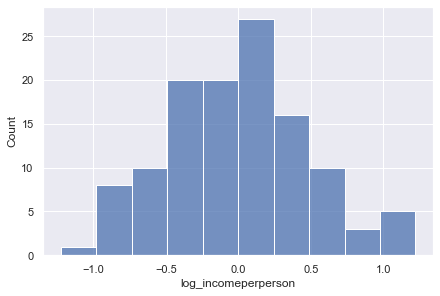

In [36]:
errores = model.predict(X_train) - y_train_log

sns.histplot(errores);

Jarque_beraResult(statistic=0.41241489461691916, pvalue=0.8136642663119029)

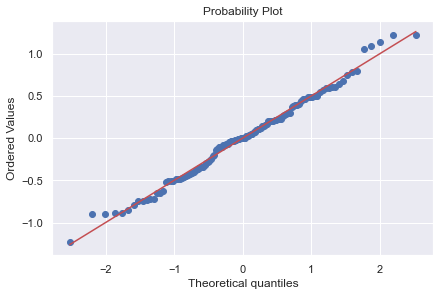

In [37]:
import matplotlib.pyplot as plt
import scipy.stats as stats

stats.probplot(errores, dist="norm", plot=plt.gca())
stats.jarque_bera(errores)

De la las gráficas anteriores concluimos que los errores siguen una distribución apróximadamente normal, lo cual podemos también confirmarlo a través del test de Jarque-Bera, que arroja un p-valor de 0.81, con lo cual podemos concluir que no hay evidencia para rechazar la hipótesis de que los errores provienen de una distribución normal. 

# Homoscedasticidad

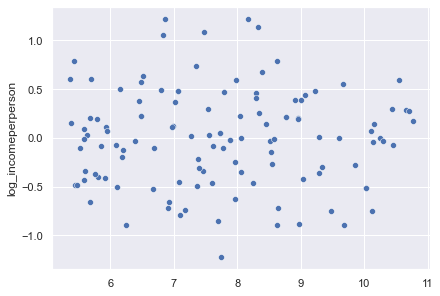

In [38]:
sns.scatterplot(x=model.predict(X_train), y=errores);

En la gráfica anterior no se observa una cambió significativo en la varianza de los errores para diferentes nivel de la variable predicha, por lo cual los errores parecen se homoscedasticos. 

## Interpretación de los coeficientes

In [39]:
# Coeficientes:
coeficientes = (
    pd.Series(
        {"constante": model.intercept_}
        | {var: coef for var, coef in zip(model.feature_names_in_, model.coef_)}
    )
    .rename("Coeficientes")
    .to_frame()
)

coeficientes

,Coeficientes
constante,2.141113
internetuserate,0.020817
breastcancerper100th,0.010168
urbanrate,0.012433
region_Central And Southern Asia,1.214445
region_Eastern And South Eastern Asia,1.174415
region_Europe And Northern America,0.816835
region_Latin America And The Caribbean,1.412258
region_Northern Africa And Western Asia,0.978910
region_Otra,1.233913


Dado que la función que se ajustó tiene transformaciones logarítmicas los coeficientes no puden inetrpretarse directamente. Recordemos que la función que se ha ajustado es $$ ln(y) = w_0
+ w_1 * x_1
+ w_2 * x_2
+ w_3 * x_3
+ w_4 * x_4
+ w_5 * x_5
+ w_6 * x_6
+ w_7 * x_7
+ w_8 * x_8
+ w_9 * x_9
+ w_{10} * x_{10}
+ w_{11} * ln(x_{11}) $$


## Variables lineales (log-lin):
En estas variables podemos interpretar que un aumento de una univedad en el regresor se relaciona con un incremente de $(exp(w_{i}) - 1)$% en el ingreso per cápita. Esto se puede probar de la siguiente manera:


$$ln(y) = w_{i} x_i + ...$$

Despejando $y$:

$$y = exp(w_{i} x_i)exp(...)$$


Si se incrementa $x_i$ en una unidad: 
$$y' = exp(w_{i} (x_i + 1))exp(...) = exp(w_{i}) exp(w_{i} x_i)exp(...) = exp(w_{i}) y $$

Luego
$$\frac{y' - y}{y}  = exp(w_{i}) - 1$$

De manera que por cada unidad en que se incrementen estas variables, el incremento en el ingreso sería: 

In [40]:
coeficientes.loc[["internetuserate", "breastcancerper100th", "urbanrate"]].pipe(
    lambda x: np.exp(x) - 1
).style.format("{:0.1%}")

,Coeficientes
internetuserate,2.1%
breastcancerper100th,1.0%
urbanrate,1.3%


De manera que:
* Un incremente en el use de internet en una de cada 100 personas implicaría un aumento del 2.1% en el ingreso per cápita.
* Un incremento en la identificación de casos de cancer de mama en una de cada 100.000 mujeres se relacina con un incremento del 1.0% del ingreso per cápita.
* Un aumento en una de cada cien personas en zonas urbanas implica un incremento de 1.3% en el PIB per cápita.

En todo caso, hay que tener cuidado en el sentido de que correlación no implica causalidad. Es posible por ejemplo, que el aumento del PIB lleve a qué mas personas utilicen internet y no al contrario. O que un mayor ingreso implica mayor detección de los casos de cancer, ´no tendría mucho sentido concluir que para aumentar el ingreso es necesario aumentar las personas con cancer de mama.


## Variables lineales (log-log):

En este caso podemos interpretar que un aumento del $\delta$% en el regresor se relaciona con un incremento del $((1 + \delta)^{w_{i}})$% en la variable objetivo. Esto se puede probar de la siguiente manera:


$$ln(y) = w_{i} ln(x_i) + ...$$

Despejando $y$:

$$y = exp(w_{i} ln(x_i))exp(...) = x_i^{w_{i}}exp(...)$$


Si se incrementa $x_i$ en un 1%:


$$y' = (x_i*(1+\delta))^{w_{i}}exp(...) = (1+\delta)^{w_{i}} y$$


$$ \frac{y' - y}{y} = (1+\delta)^{w_{i}} - 1$$

De manera que por cada 1% en que se incremente esta variable, el incremento en el ingreso sería: 

In [41]:
coeficientes.loc[["log_relectricperperson"]].pipe(lambda x: 1.01**x - 1).rename(
    {"log_relectricperperson": "relectricperperson"}
).style.format("{:0.1%}")

,Coeficientes
relectricperperson,0.5%


Luego un incremento del 1% en el uso de electricidad por persona se relaciona con un incremento del 0.5% en el ingreso per cápita. 

# Generación de resultados

## Principales hallazgos

De acuerdo con los resultados de la regresión aplicada se encontró que: la detección de cancer de seno, el uso de internet, el porcentaje de población urbana y el uso de energía por persona resultan buenos predictores del PIB per cápita. En particular se encontró que un incremento del 1% en el uso de internet se relaciona con un incremento del 2.1% en el el PIB per cápita;  un aumento aumento en la detección de cancer en una de cada 100.000 mujer se relaciona con un incremento del PIB del 1% (lo cual podría interpretarse como una proxy de la calidad del sistema de salud del país); un aumento de un punto en la tasa de población urbana se relaciona con un incremento del 1.3% del PIB er capita, y un incremento del 1% en el uso de energía con un cremento del 0.5%.

*¿qué conjunto de políticas públicas recomendaría implementar, a partir de la premisa de que la mejora en estas áreas indicaría al Banco Mundial que el país es estable, está en una trayectoria de desarrollo sostenible y tiene la capacidad de administrar y reembolsar préstamos de manera efectiva?*

Estas conclusiones deben ser tomadas con cuidado, pues la regresión no explica la causalidad entre los fenómenos, por lo que puede ser que el incremento del PIB lleve a aumentar estos indicadores y no al contrario. Sin embargo, de estos resultas sería razonable esperar que los siguientes tipos de políticas puedan llevar a un aumento del PIB per cápita:

- Inversión para mejorar el sistema de salud.
- Aumento de la covertura de internet.
- Reducción del costo de la energía eléctrica.
- Mejoras en el desarrollo urbano y migración campo-ciudad. 

De todas estas políticas, la covertura de internet parece tener el mayor efecto por lo que podría ser una política estrella, en particular si puede resultar relativamente menos costos incrementar la covertura de internet que reducir los costos de la energía o mejorar el sistema de salud.